In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, BinaryAccuracy, MulticlassAccuracy
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, BinaryAccuracy, MulticlassAccuracy
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold

import random
from PIL import Image
from pathlib import Path
from torchinfo import summary
import copy

from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from collections import Counter

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data import

In [7]:
base_dir = os.getcwd()
image_dir = os.path.join(base_dir,'data','patch_images')
labels_main_dir = os.path.join(base_dir,"data","data_labels_mainData.csv")
extra_labels_path = os.path.join(base_dir,"data","data_labels_extraData.csv")

In [8]:
# Load the CSVs
main_df = pd.read_csv(labels_main_dir )
extra_df = pd.read_csv(extra_labels_path)

# Display the first few rows
print("Main Data Labels:")
display(main_df.head())

print("\nExtra Data Labels:")
display(extra_df.head())

Main Data Labels:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0



Extra Data Labels:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [10]:
# Add dummy column to extra_df so both have same structure
extra_df['cellType'] = None  # Task 1 doesn't need this anyway

# Combine the two
combined_df = pd.concat([main_df, extra_df], ignore_index=True)

# Optional: Reset index
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df.drop(columns=['cellTypeName','cellType'])
display(combined_df.head())

print("Main df shape:",main_df.shape)
print("Extra df shape:",extra_df.shape)
print("Combined shape:", combined_df.shape)

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


Main df shape: (9896, 6)
Extra df shape: (10384, 5)
Combined shape: (20280, 4)


In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

In [12]:
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['ImageName']
        label = self.data.iloc[idx]['isCancerous']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [13]:
from sklearn.model_selection import train_test_split

combined_df['patientID'] = combined_df['ImageName'].apply(lambda x: x.split('_')[0])  # or other rule

unique_patients = combined_df['patientID'].unique()
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

train_df = combined_df[combined_df['patientID'].isin(train_patients)]
val_df = combined_df[combined_df['patientID'].isin(val_patients)]
test_df = combined_df[combined_df['patientID'].isin(test_patients)]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 14196
Validation set size: 3042
Test set size: 3042


In [14]:
train_dataset = CancerImageDataset(train_df, image_dir, transform)
val_dataset = CancerImageDataset(val_df, image_dir, transform)
test_dataset = CancerImageDataset(test_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model

In [15]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

### Helper functions

In [16]:
def binary_train_model_v0(model, train_data_loader, val_data_loader, loss_function, optimizer, epoch_count, early_stop_count, device):

    """
    Trains and validates a binary classification model with early stopping.

    Returns:
        best model, train losses, train accuracies, val losses, val accuracies
    """

    model = model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    train_accuracy_fn = BinaryAccuracy().to(device)
    val_accuracy_fn = BinaryAccuracy().to(device)

    best_val_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())
    patience_counter = early_stop_count

    for epoch in range(epoch_count):
        print("-" * 100)
        print(f"Epoch {epoch+1}/{epoch_count}")

        # ---- TRAINING ----
        model.train()
        train_accuracy_fn.reset()
        running_train_loss = 0.0

        for images, labels in tqdm(train_data_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)  # shape: [B, 1]
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            train_accuracy_fn.update(preds, labels.int())

        avg_train_loss = running_train_loss / len(train_data_loader.dataset)
        avg_train_accuracy = train_accuracy_fn.compute().item()

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # ---- VALIDATION ----
        model.eval()
        val_accuracy_fn.reset()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_data_loader, desc="Validation", leave=False):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = loss_function(outputs, labels)

                running_val_loss += loss.item() * images.size(0)

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).long()
                val_accuracy_fn.update(preds, labels.int())

        avg_val_loss = running_val_loss / len(val_data_loader.dataset)
        avg_val_accuracy = val_accuracy_fn.compute().item()

        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Train loss: {avg_train_loss:.4f} | Train acc: {avg_train_accuracy:.4f}")
        print(f"Val loss  : {avg_val_loss:.4f} | Val acc  : {avg_val_accuracy:.4f}")
        print(f"Epoch {epoch+1} | Val loss: {avg_val_loss:.4f} | Best so far: {best_val_loss:.4f} | Patience left: {patience_counter}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = early_stop_count
        else:
            patience_counter -= 1
            if patience_counter == 0:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model_weights)

    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [36]:
def binary_evaluate_model_predictions(model, val_data_loader, device):
    """
    Evaluates a binary classification model (using BCELoss with Sigmoid in model)
    and returns predictions and targets.

    Returns:
        all_predictions (tensor of shape [N])
        all_targets (tensor of shape [N])
    """

    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="Evaluation", leave=False):
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # shape: [B, 1]

            outputs = model(images)  # already sigmoid probabilities in [0, 1]
            predictions = (outputs > 0.5).long()  # threshold at 0.5

            all_predictions.append(predictions.cpu())
            all_targets.append(labels.cpu().long())

    all_predictions = torch.cat(all_predictions).squeeze()  # shape: [N]
    all_targets = torch.cat(all_targets).squeeze()          # shape: [N]

    return all_predictions, all_targets

In [18]:
def evaluate_per_class_metrics_binary(predictions, targets):
    """ 
    Generates the classification report for binary classification.
    """

    class_names = ["Negative", "Positive"]  # Update these to your actual label meanings if needed
    print("Classification Report:\n")
    report = classification_report(y_true=targets, y_pred=predictions, target_names=class_names, digits=3)
    print(report)


In [19]:
def plot_confusion_metrics_binary(predictions, targets):
    """ 
    Plots the confusion matrix for binary classification.
    """

    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

### Training

In [ ]:
#instantiating a model
model_t = CNNBaseline()

#defining loss function and  optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_t.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = binary_train_model_v0(
    model=model_t,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    epoch_count=10,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = binary_evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

----------------------------------------------------------------------------------------------------
Epoch 1/30


Train loss: 0.3530 | Train acc: 0.3492
Val loss  : 0.2878 | Val acc  : 0.3429
Epoch 1 | Val loss: 0.2878 | Best so far: inf | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 2/30


Train loss: 0.2957 | Train acc: 0.3497
Val loss  : 0.2842 | Val acc  : 0.3435
Epoch 2 | Val loss: 0.2842 | Best so far: 0.2878 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 3/30


Train loss: 0.2896 | Train acc: 0.3569
Val loss  : 0.3010 | Val acc  : 0.3521
Epoch 3 | Val loss: 0.3010 | Best so far: 0.2842 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 4/30


Train loss: 0.2645 | Train acc: 0.3645
Val loss  : 0.2716 | Val acc  : 0.3517
Epoch 4 | Val loss: 0.2716 | Best so far: 0.2842 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 5/30


Train loss: 0.2478 | Train acc: 0.3719
Val loss  : 0.2802 | Val acc  : 0.3475
Epoch 5 | Val loss: 0.2802 | Best so far: 0.2716 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 6/30


Train loss: 0.2352 | Train acc: 0.3698
Val loss  : 0.2692 | Val acc  : 0.3652
Epoch 6 | Val loss: 0.2692 | Best so far: 0.2716 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 7/30


Train loss: 0.2197 | Train acc: 0.3820
Val loss  : 0.2838 | Val acc  : 0.3692
Epoch 7 | Val loss: 0.2838 | Best so far: 0.2692 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 8/30


Train loss: 0.2008 | Train acc: 0.3759
Val loss  : 0.2947 | Val acc  : 0.3586
Epoch 8 | Val loss: 0.2947 | Best so far: 0.2692 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 9/30


Train loss: 0.1694 | Train acc: 0.3845
Val loss  : 0.3228 | Val acc  : 0.3803
Epoch 9 | Val loss: 0.3228 | Best so far: 0.2692 | Patience left: 8
----------------------------------------------------------------------------------------------------
Epoch 10/30


Train loss: 0.1442 | Train acc: 0.4093
Val loss  : 0.3802 | Val acc  : 0.3912
Epoch 10 | Val loss: 0.3802 | Best so far: 0.2692 | Patience left: 7
----------------------------------------------------------------------------------------------------
Epoch 11/30


Train loss: 0.1304 | Train acc: 0.4226
Val loss  : 0.3774 | Val acc  : 0.4254
Epoch 11 | Val loss: 0.3774 | Best so far: 0.2692 | Patience left: 6
----------------------------------------------------------------------------------------------------
Epoch 12/30


Train loss: 0.1247 | Train acc: 0.4308
Val loss  : 0.3824 | Val acc  : 0.4201
Epoch 12 | Val loss: 0.3824 | Best so far: 0.2692 | Patience left: 5
----------------------------------------------------------------------------------------------------
Epoch 13/30


Train loss: 0.0971 | Train acc: 0.4562
Val loss  : 0.5198 | Val acc  : 0.4155
Epoch 13 | Val loss: 0.5198 | Best so far: 0.2692 | Patience left: 4
----------------------------------------------------------------------------------------------------
Epoch 14/30


Train loss: 0.0823 | Train acc: 0.4906
Val loss  : 0.4992 | Val acc  : 0.4583
Epoch 14 | Val loss: 0.4992 | Best so far: 0.2692 | Patience left: 3
----------------------------------------------------------------------------------------------------
Epoch 15/30


Train loss: 0.0657 | Train acc: 0.5210
Val loss  : 0.5435 | Val acc  : 0.4652
Epoch 15 | Val loss: 0.5435 | Best so far: 0.2692 | Patience left: 2
----------------------------------------------------------------------------------------------------
Epoch 16/30


Train loss: 0.0700 | Train acc: 0.5440
Val loss  : 0.5539 | Val acc  : 0.4819
Epoch 16 | Val loss: 0.5539 | Best so far: 0.2692 | Patience left: 1
Early stopping triggered.


Classification Report:

              precision    recall  f1-score   support

    Negative      1.000     0.034     0.066      1999
    Positive      0.351     1.000     0.519      1043

    accuracy                          0.365      3042
   macro avg      0.675     0.517     0.293      3042
weighted avg      0.777     0.365     0.221      3042



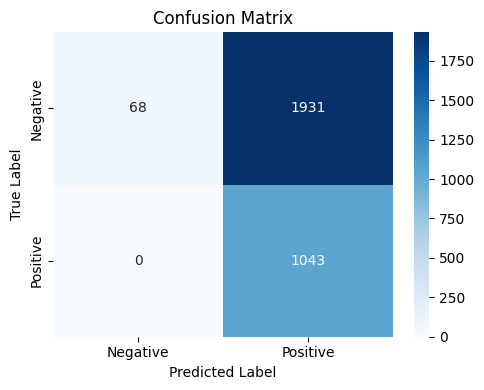

In [21]:
evaluate_per_class_metrics_binary(val_predictions,val_targets)
plot_confusion_metrics_binary(val_predictions, val_targets)

### Vasi's train loop

In [22]:
model = CNNBaseline().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.3452
Epoch [2/10], Loss: 0.2968
Epoch [3/10], Loss: 0.2807
Epoch [4/10], Loss: 0.2590
Epoch [5/10], Loss: 0.2358
Epoch [6/10], Loss: 0.2120
Epoch [7/10], Loss: 0.1895
Epoch [8/10], Loss: 0.1540
Epoch [9/10], Loss: 0.1219
Epoch [10/10], Loss: 0.1019


In [23]:

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            preds = (outputs > 0.5).astype(int).flatten()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

print("Validation Performance:")
evaluate(model, val_loader)

Validation Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      1999
         1.0       0.80      0.85      0.82      1043

    accuracy                           0.88      3042
   macro avg       0.86      0.87      0.86      3042
weighted avg       0.88      0.88      0.88      3042

[[1780  219]
 [ 161  882]]


### Double checking

In [24]:
def binary_train_check(model, train_data_loader, loss_function, optimizer, epoch_count, device):


    model = model.to(device)

    train_losses = []
    train_accuracies = []

    train_accuracy_fn = BinaryAccuracy().to(device)


    for epoch in range(epoch_count):
        print("-" * 100)
        print(f"Epoch {epoch+1}/{epoch_count}")

        # ---- TRAINING ----
        model.train()
        train_accuracy_fn.reset()
        running_train_loss = 0.0

        for images, labels in tqdm(train_data_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)  # shape: [B, 1]
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            train_accuracy_fn.update(preds, labels.int())

        avg_train_loss = running_train_loss / len(train_data_loader.dataset)
        avg_train_accuracy = train_accuracy_fn.compute().item()

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        print(f"Train loss : {avg_train_loss:.4f} \t| Train accuracy {avg_train_accuracy:.4f}")

In [26]:
#instantiating a model
model_t = CNNBaseline()

#defining loss function and  optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_t.parameters(), lr=0.001)

#model training
binary_train_check(
    model=model_t,
    train_data_loader=train_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    epoch_count=10,
    device=device
)

----------------------------------------------------------------------------------------------------
Epoch 1/10


Train loss : 0.3575 	| Train accuracy 0.3516
----------------------------------------------------------------------------------------------------
Epoch 2/10


Train loss : 0.3041 	| Train accuracy 0.3590
----------------------------------------------------------------------------------------------------
Epoch 3/10


Train loss : 0.2849 	| Train accuracy 0.3609
----------------------------------------------------------------------------------------------------
Epoch 4/10


Train loss : 0.2688 	| Train accuracy 0.3648
----------------------------------------------------------------------------------------------------
Epoch 5/10


Train loss : 0.2478 	| Train accuracy 0.3719
----------------------------------------------------------------------------------------------------
Epoch 6/10


Train loss : 0.2335 	| Train accuracy 0.3770
----------------------------------------------------------------------------------------------------
Epoch 7/10


Train loss : 0.2117 	| Train accuracy 0.3785
----------------------------------------------------------------------------------------------------
Epoch 8/10


Train loss : 0.1919 	| Train accuracy 0.3878
----------------------------------------------------------------------------------------------------
Epoch 9/10


Train loss : 0.1689 	| Train accuracy 0.3859
----------------------------------------------------------------------------------------------------
Epoch 10/10


Train loss : 0.1425 	| Train accuracy 0.4055


In [30]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            preds = (outputs > 0.5).astype(int).flatten()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

print("Validation Performance:")
evaluate(model_t, val_loader)

Validation Performance:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      1999
         1.0       0.85      0.82      0.84      1043

    accuracy                           0.89      3042
   macro avg       0.88      0.87      0.88      3042
weighted avg       0.89      0.89      0.89      3042

[[1845  154]
 [ 184  859]]


In [37]:
val_predictions, val_targets = binary_evaluate_model_predictions(model=model_t, val_data_loader=val_loader, device=device)

In [38]:
evaluate_per_class_metrics_binary(val_predictions,val_targets)

Classification Report:

              precision    recall  f1-score   support

    Negative      0.909     0.923     0.916      1999
    Positive      0.848     0.824     0.836      1043

    accuracy                          0.889      3042
   macro avg      0.879     0.873     0.876      3042
weighted avg      0.888     0.889     0.888      3042



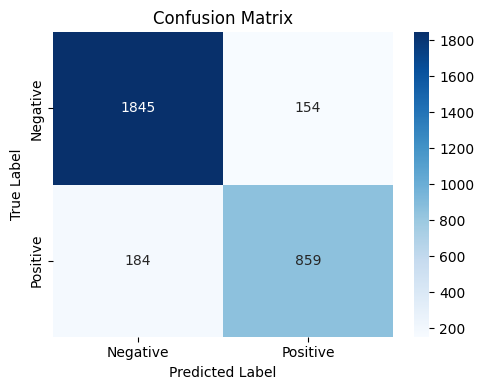

In [39]:
plot_confusion_metrics_binary(val_predictions,val_targets)